# Transfer Learning

## 1.3.2 폴더 준비

data 폴더를 만들고, hymenoptera data를 다운로드

In [1]:
# !rm -rf data
# !mkdir data
# !wget "https://download.pytorch.org/tutorial/hymenoptera_data.zip" -O hymenoptera_data.zip
# !unzip -o hymenoptera_data.zip
# !rm hymenoptera_data.zip
# !\mv -f hymenoptera_data data/

for loop의 경과 시간과 남은 시간을 측정하는 tqdm 패키지를 설치

In [2]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, transforms

In [5]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## 1.3.5 Dataset 작성

In [6]:
class ImageTransform():
    """
    화상 전처리 클래스. 훈련 시와 검증 시의 동작이 다르다.
    화상 크기를 Resize하고 색상을 Normalize한다.
    훈련 시에는 RandomResizeCrop과 RandomHorizontalFlip으로 Data Augmentation을 수행한다.
    
    Attributes
    ----------
    resize: int
    mean:   (R, G, B)
    std:    (R, G, B)
    """
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)
                ),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

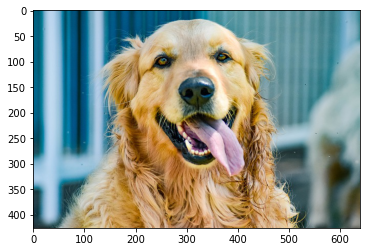

In [7]:
# Retriever
img = Image.open("../week01/images/goldenretriever-3724972_640.jpg")
plt.imshow(img)
plt.show()

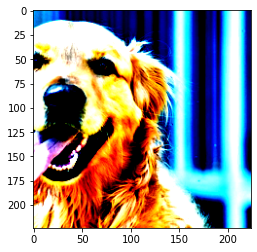

In [8]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(224, mean, std)
img_t = transform(img)
img_t = img_t.permute(1,2,0)
img_t = torch.clip(img_t, 0, 1)
plt.imshow(img_t)
plt.show()

In [9]:
def make_datapath_list(phase="train"):
    """
    데이터의 경로를 저장한 리스트 작성
    """
    root_path = "./data/hymenoptera_data/"
    target_path = osp.join(root_path+phase+'/**/*.jpg')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
    
    return path_list

In [10]:
train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


In [11]:
len(train_list)

243

In [12]:
len(val_list)

153

In [13]:
class HymenopteraDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        img_transformed = self.transform(
            img, self.phase
        )
        
        if self.phase == 'train':
            label = img_path[30:34]
        elif self.phase == 'val':
            label = img_path[28:32]
            
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1
            
        return img_transformed, label

In [14]:
train_dataset = HymenopteraDataset(
    file_list=train_list,
    transform=ImageTransform(224, mean, std),
    phase='train'
)

val_dataset = HymenopteraDataset(
    file_list = val_list,
    transform=ImageTransform(224, mean, std),
    phase='val'
)

1


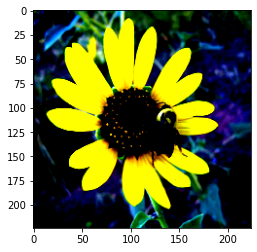

In [15]:
index = 0
img, label = train_dataset[index]
print(label)
#img.permute(1,2,0) |> torch.clip$(?, 0, 1) |> plt.imshow
img = img.permute(1,2,0)
img = torch.clip(img, 0, 1)
plt.imshow(img)
plt.show()

## 1.3.6 DataLoader 작성

In [16]:
batch_size = 32

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
)

dataloaders_dict = {
    "train": train_dataloader,
    "val": val_dataloader,
}

In [17]:
batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0])


## 1.3.7 Network Model 작성

In [18]:
net = models.vgg16(pretrained=True)

print(net.classifier)

net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

net.train()

print("네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.")

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.


In [19]:
net.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

## 1.3.8 Loss Function 정의

In [20]:
criterion = nn.CrossEntropyLoss()

## 1.3.9 Optimization 정의

In [21]:
params_to_update = []

update_param_names = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False
        
print("--------------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
--------------
[Parameter containing:
tensor([[-0.0147, -0.0112, -0.0021,  ..., -0.0019, -0.0098,  0.0003],
        [-0.0043,  0.0073,  0.0097,  ...,  0.0027, -0.0058,  0.0037]],
       requires_grad=True), Parameter containing:
tensor([-0.0002,  0.0046], requires_grad=True)]


In [22]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

## 1.3.10 Train & Validation

In [23]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-------------------")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            # To check validate performance
            if (epoch == 0) and (phase == 'train'):
                continue
            
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, dim=1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() + inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

In [24]:
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/2
-------------------


/usr/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /build/python-pytorch/src/pytorch-1.9.0-opt/c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 1.0245 Acc: 0.4967
Epoch 2/2
-------------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 1.0156 Acc: 0.7407


100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

val Loss: 1.0058 Acc: 0.9542


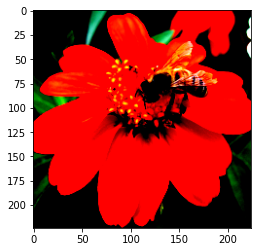

1


In [25]:
img_t, label = val_dataset[0]
img = img_t.permute(1,2,0)
img = img.clip(0, 1)
plt.imshow(img)
plt.show()
print(label)

In [26]:
net.eval()
pred = torch.max(net(img_t.unsqueeze(0)), dim=1)[1].item()
if pred == 0:
    print("Ant!")
elif pred == 1:
    print("Bee!")

Bee!
